# Step 2: Data Cleaning & Validation

Create Spark Session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col

C:\Users\USER\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
# code for Data cleaning and validation
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, when, count, isnan

spark = SparkSession.builder \
    .appName("Crypto Data Cleaning") \
    .getOrCreate()


Load CSV File

In [7]:
url = "synthetic_bitcoin_2014_2023.csv"
df = spark.read.csv(url, header=True, inferSchema=True)
df.show(5)
print(f"Total Rows: {df.count()}")


+----------+------------------+------------------+------------------+------------------+------+------------------+
|      Date|              Open|              High|               Low|             Close|Volume|         MarketCap|
+----------+------------------+------------------+------------------+------------------+------+------------------+
|2014-01-01|20968.082996411034| 20829.91171069015|20870.791135428568|20945.270521984607| 19033|3986513.3384493305|
|2014-01-02| 19522.47194008754|19797.146770887925|19423.537425631155|19674.704767049698| 36088| 7100207.456332895|
|2014-01-03| 20701.45138135251| 20785.33115376397|20329.565015906777| 20650.36962066113| 44465| 9182186.851826971|
|2014-01-04|  20938.4878660132| 20980.01940620715| 20754.12859635343|20866.669464301012| 18527|3865967.8516510488|
|2014-01-05|20456.964154911486|20312.142864650312|20309.665064519202| 20509.47348177957| 12964|2658848.1421779036|
+----------+------------------+------------------+------------------+-----------

In [8]:
#convert into pandas
new_df = df.toPandas()
new_df.describe()

,Open,High,Low,Close,Volume,MarketCap
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3.652000e+03
mean,20518.326847,20620.256478,20415.900567,20518.567442,24975.151150,5.125475e+06
std,1012.754233,1016.650026,1017.014598,1012.619103,14298.152302,2.948781e+06
min,17314.292888,17423.804853,17112.420634,17360.706180,1010.000000,2.054398e+05
25%,19839.450904,19939.396563,19749.518577,19841.025237,12369.250000,2.505013e+06
50%,20518.574512,20632.069615,20417.141459,20527.579994,24638.000000,5.051483e+06
75%,21210.717070,21306.589269,21099.361843,21204.822694,37274.500000,7.641792e+06
max,23962.453705,24180.450308,24077.988939,24102.985121,49975.000000,1.144913e+07


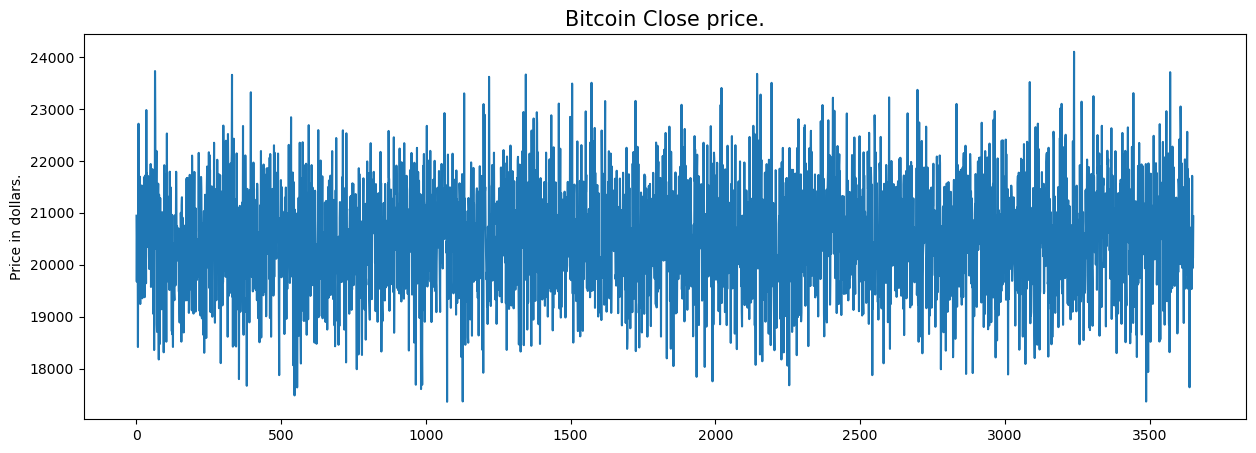

In [9]:
#plotting the Bitcoin Close Price
plt.figure(figsize=(15, 5))
plt.plot(new_df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

Handle Missing / Null Values

In [8]:
from pyspark.sql.functions import col, when, count

df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()


+----+----+----+---+-----+------+---------+
|Date|Open|High|Low|Close|Volume|MarketCap|
+----+----+----+---+-----+------+---------+
|   0|   0|   0|  0|    0|     0|        0|
+----+----+----+---+-----+------+---------+



C:\Users\USER\AppData\Local\Temp\ipykernel_23208\3681706781.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1)
C:\Users\USER\AppData\Local\Temp\ipykernel_23208\3681706781.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[col])
C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

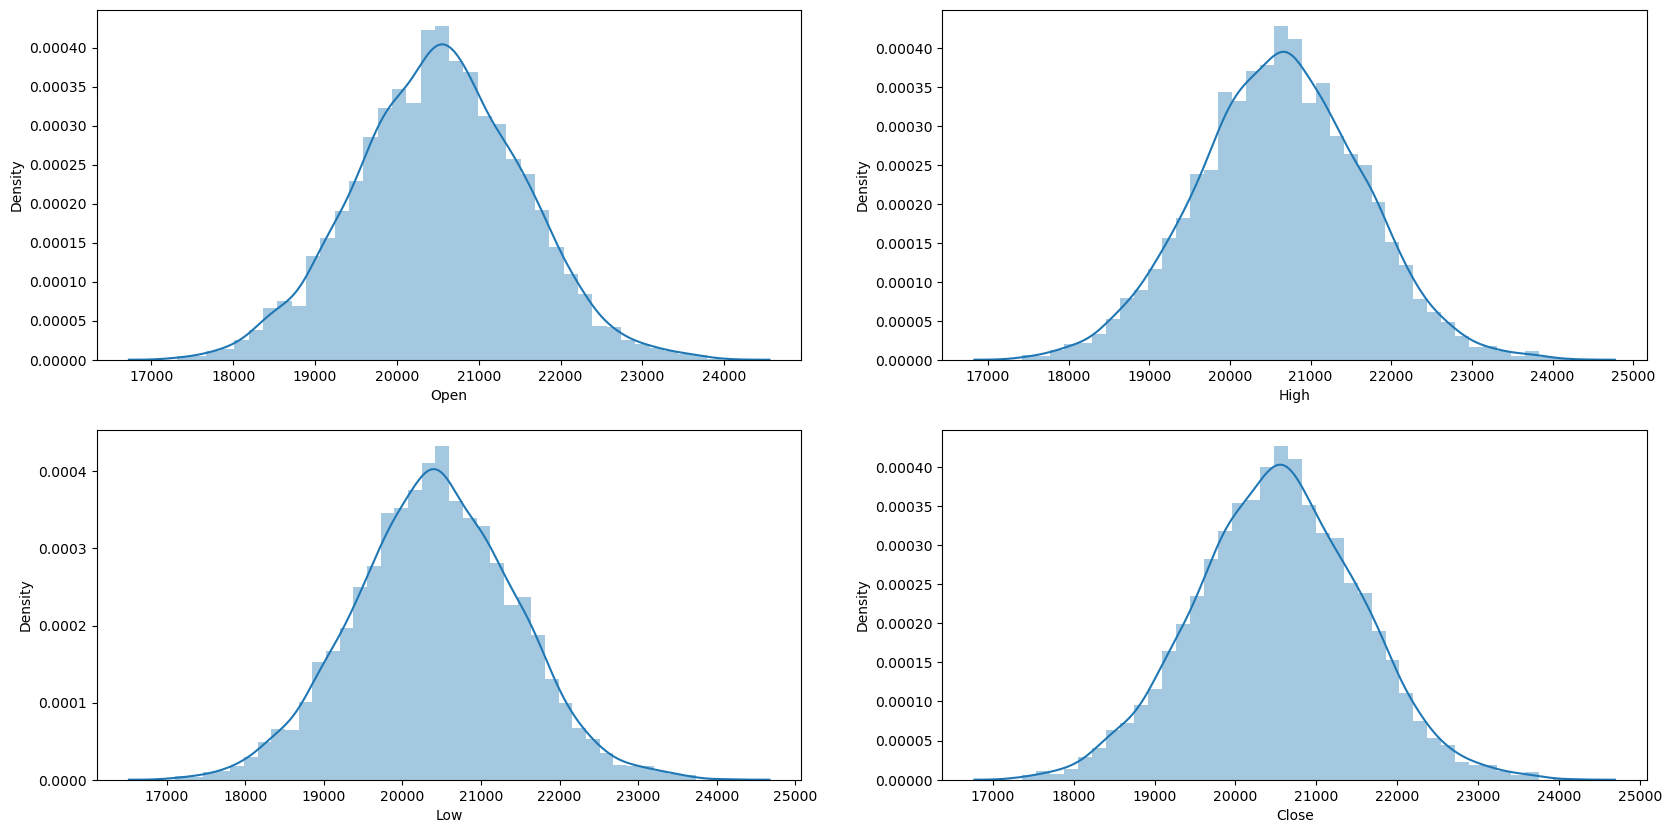

In [9]:
#plotting the graph of features related
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.distplot(new_df[col])
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_23208\1759364330.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1)


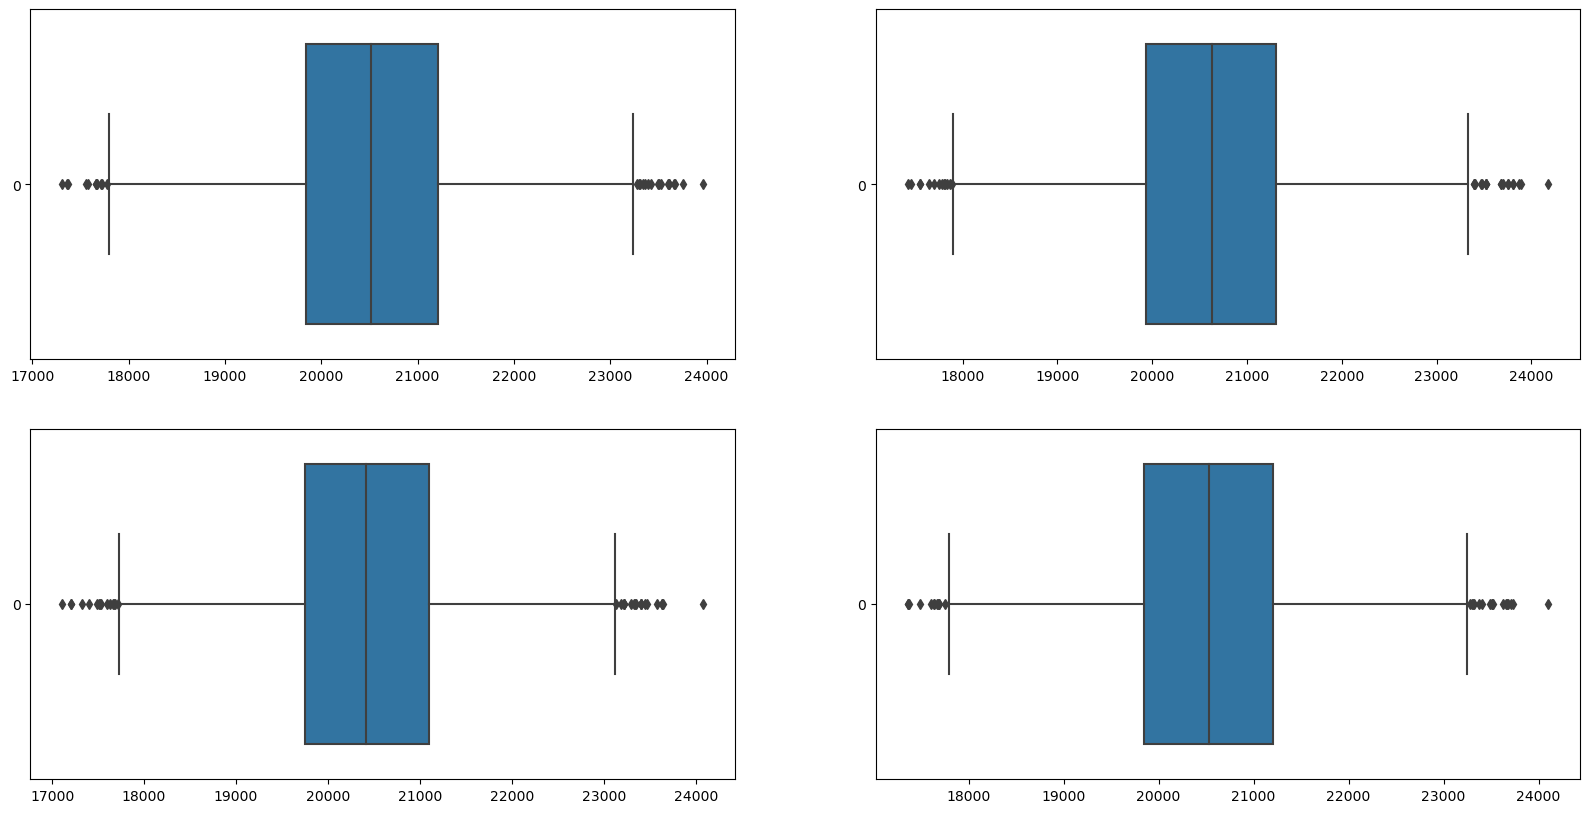

In [10]:
#plotting histogram 
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.boxplot(new_df[col], orient='h')
plt.show()

Remove Duplicates

In [11]:
before = df.count()
df_no_duplicates = df.dropDuplicates()
after = df_no_duplicates.count()
print(f"Removed {before - after} duplicate rows")



Removed 0 duplicate rows


Detect & Remove Outliers (on “Close”)

In [13]:
from pyspark.sql.functions import mean, stddev, col

stats = df_no_duplicates.select(
    mean(col("Close")).alias("mean"),
    stddev(col("Close")).alias("stddev")
).collect()

mean_val = stats[0]["mean"]
std_val = stats[0]["stddev"]

print(f"Mean Close Price: {mean_val:.2f}, Std Dev: {std_val:.2f}")

df_no_outliers = df_no_duplicates.filter(
    (col("Close") >= mean_val - 3 * std_val) &
    (col("Close") <= mean_val + 3 * std_val)
)

print(f"After removing outliers: {df_no_outliers.count()} rows")

Mean Close Price: 20518.57, Std Dev: 1012.62
After removing outliers: 3642 rows


In [21]:
#Convert into the Pandas
pdf_no_outliers = df_no_outliers.select('Date', 'Close').toPandas()
pdf_no_outliers['Date'] = pd.to_datetime(pdf_no_outliers['Date'])

#Convert the Original PySpark DataFrame to Pandas for Comparison
pdf_original = df_no_duplicates.select('Date', 'Close').toPandas()
pdf_original['Date'] = pd.to_datetime(pdf_original['Date'])

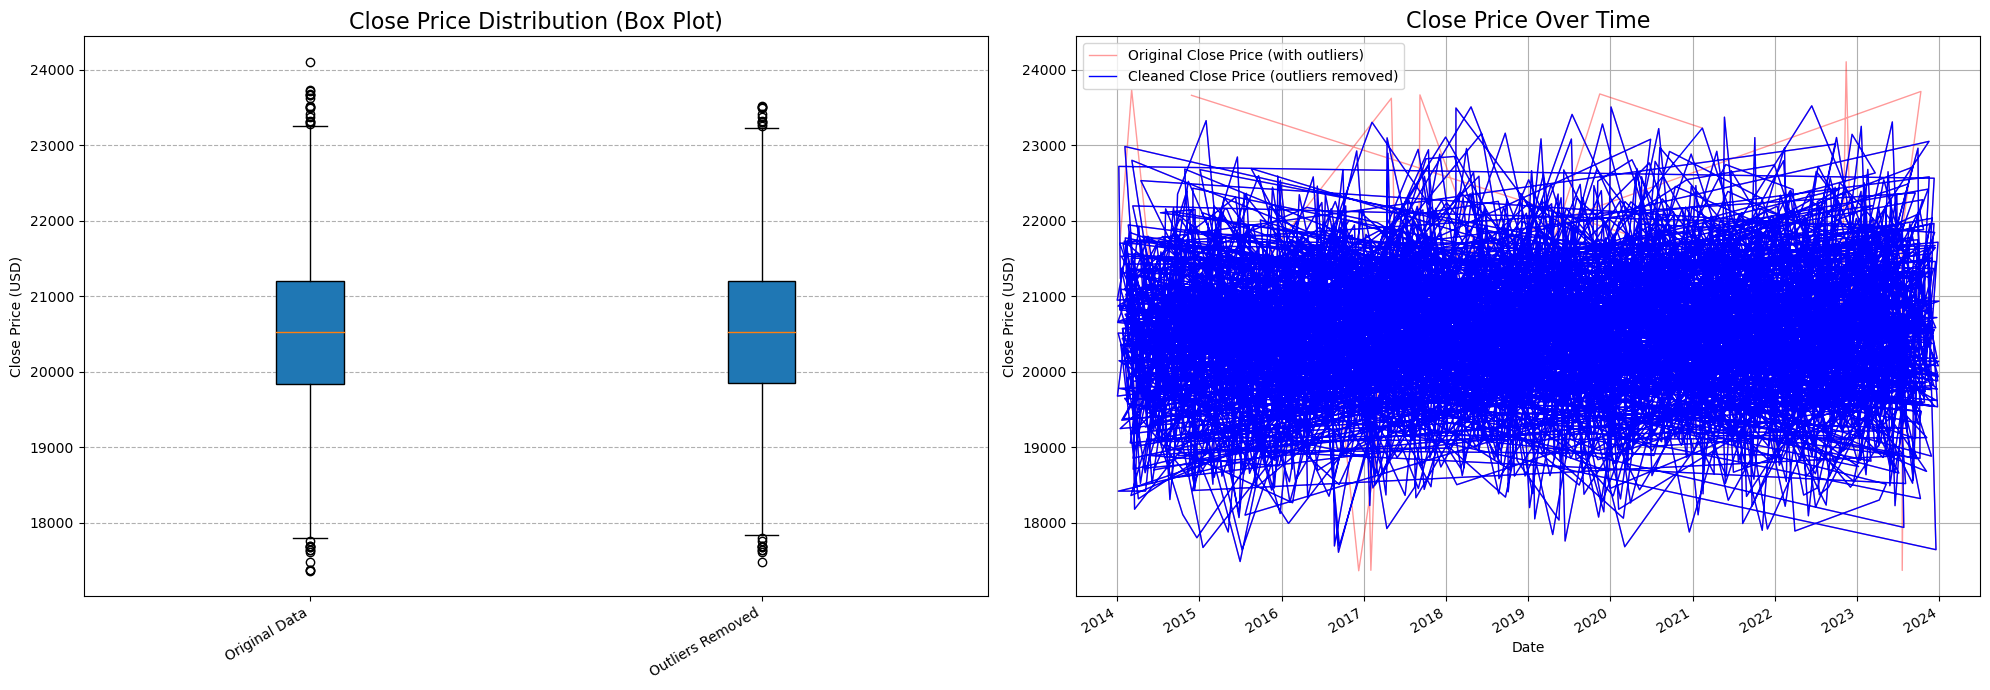

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# --- Subplot 1: Box Plot Comparison ---
axes[0].boxplot(
    [pdf_original['Close'], pdf_no_outliers['Close']],
    labels=['Original Data', 'Outliers Removed'],
    patch_artist=True,
    vert=True # Vertical boxes
)
axes[0].set_title('Close Price Distribution (Box Plot)', fontsize=16)
axes[0].set_ylabel('Close Price (USD)')
axes[0].grid(axis='y', linestyle='--')
axes[0].ticklabel_format(style='plain', axis='y') # Use plain numbers for large values

# --- Subplot 2: Comparison ---
# Plotting the original data
axes[1].plot(pdf_original['Date'], pdf_original['Close'], 
             label='Original Close Price (with outliers)', 
             color='red', 
             alpha=0.4, 
             linewidth=1)

# Plotting the cleaned data
axes[1].plot(pdf_no_outliers['Date'], pdf_no_outliers['Close'], 
             label='Cleaned Close Price (outliers removed)', 
             color='blue', 
             linewidth=1)

axes[1].set_title('Close Price Over Time', fontsize=16)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Close Price (USD)')
axes[1].legend()
axes[1].grid(True)
plt.gcf().autofmt_xdate()

# Display the final plot
plt.tight_layout()
plt.show()

Validate Cleaned Data

In [21]:
df_no_outliers.describe(["Open", "High", "Low", "Close", "Volume"]).show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|              Open|              High|               Low|             Close|            Volume|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              3642|              3642|              3642|              3642|              3642|
|   mean| 20514.83483401755|20616.696558847096| 20412.37077296476| 20514.97795462582|24989.030203185062|
| stddev|1000.3915896959207|1004.2657343796701|1004.2033573771114| 1000.015953448771|14303.377773427568|
|    min|17554.468854404855| 17552.02489278787|17327.930855040104|17483.292078958923|              1010|
|    max| 23528.89543327984|23808.953125325203|23406.057555410658| 23519.65383486466|             49975|
+-------+------------------+------------------+------------------+------------------+------------------+



Save Cleaned Data (optional)

In [22]:
df_no_outliers.toPandas().to_csv(r"C:\Users\bnsah\OneDrive\文档\PROJECTS(FINAL)\PROJECTS\Academic_project\BDA_BITCOIN\CryptoPredict\data\cleaned_bitcoin_data.csv", index=False)


# Step 3: Feature Engineering

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, date_format, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer

# --- 1. Setup and Data Loading ---

# Initialize Spark Session
spark = SparkSession.builder.appName("BitcoinAdvancedFeatures").getOrCreate()

# Load the dataset
file_path = "cleaned_bitcoin_data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Preprocessing: Convert 'Date' and cast columns to double
df = df.withColumn("Date", col("Date").cast("date"))
cols_to_cast = ["Open", "High", "Low", "Close", "Volume", "MarketCap"]
for c in cols_to_cast:
    df = df.withColumn(c, col(c).cast("double"))

# Order by Date for all time series operations
df = df.orderBy("Date")

# --- 2. Advanced Feature Engineering ---

# Define a general Window spec ordered by Date
window_spec_lag = Window.orderBy("Date")

# A. Lag Features (Prices and Volume)
lag_features_base = ["Close", "Open", "High", "Low", "Volume"]
lag_periods = [1, 2, 3, 7]

for feature in lag_features_base:
    for i in lag_periods:
        new_col_name = f"{feature}Lag{i}"
        df = df.withColumn(
            new_col_name,
            lag(col(feature), i).over(window_spec_lag)
        )

# B. Moving Average (7-day Simple Moving Average on Close)
# Define window for 7-day trailing average (6 preceding rows + current row)
window_spec_ma = Window.orderBy("Date").rowsBetween(-6, 0)
df = df.withColumn(
    "Close_SMA_7",
    F.avg(F.col("Close")).over(window_spec_ma)
)

# C. Log Returns (Log(Close_t / Close_t-1))
# Need the Close price from the previous day for the calculation
df = df.withColumn(
    "Prev_Close",
    F.lag(F.col("Close"), 1).over(window_spec_lag)
)
df = df.withColumn(
    "Log_Returns",
    F.log(F.col("Close") / F.col("Prev_Close"))
).drop("Prev_Close") # Drop the temporary lag column

# D. Volume Ratio (Volume / MarketCap)
df = df.withColumn(
    "Volume_to_MarketCap_Ratio",
    F.col("Volume") / F.col("MarketCap")
)

# E. Time-Based Features
df = df.withColumn("DayOfWeek", date_format(col("Date"), "E"))
df = df.withColumn("Month", date_format(col("Date"), "M").cast("int"))

# --- 3. Prepare X and Y DataFrames ---

# 1. Drop rows with any Nulls (due to lag, SMA, and log returns calculations)
df_clean = df.na.drop()

# 2. StringIndex the categorical 'DayOfWeek' column
indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_Index")
df_indexed = indexer.fit(df_clean).transform(df_clean)

# 3. Define the Target DataFrame (Y)
target_col = "Close"
y_df = df_indexed.select("Date", col(target_col).alias("Target"))

# 4. Define the Feature DataFrame (X)
# X includes all engineered features: lag, MA, returns, ratio, and time features
engineered_features = [c for c in df_indexed.columns if 'Lag' in c or 'SMA' in c or 'Returns' in c or 'Ratio' in c]
x_cols_final = ["Date"] + engineered_features + ["DayOfWeek_Index", "Month"]
x_df = df_indexed.select(x_cols_final)

# --- 4. Output the Head Values (First 10) ---

print("\n--- Feature DataFrame (X) Head (First 10 Rows) ---")
# Showing a selection of the new and existing features for readability
x_df.select(
    "Date", "CloseLag1", "Close_SMA_7", "Log_Returns",
    "Volume_to_MarketCap_Ratio", "DayOfWeek_Index"
).show(10)

print("\n--- Target DataFrame (Y) Head (First 10 Rows) ---")
y_df.show(10)


--- Feature DataFrame (X) Head (First 10 Rows) ---
+----------+------------------+------------------+--------------------+-------------------------+---------------+
|      Date|         CloseLag1|       Close_SMA_7|         Log_Returns|Volume_to_MarketCap_Ratio|DayOfWeek_Index|
+----------+------------------+------------------+--------------------+-------------------------+---------------+
|2014-01-08|20664.129714703664|20499.695547556465| 0.09471150540700762|     0.004402001603979393|            4.0|
|2014-01-09| 22716.93856485658|20566.723264023138|-0.12020938592566809|     0.004964282291161346|            6.0|
|2014-01-10|20143.898782316417| 20441.87096296607|-0.01841196732594...|     0.005056531129785149|            5.0|
|2014-01-11|19776.403513261666|20443.399004228155| 0.05417610855001278|     0.004789876327427995|            0.0|
|2014-01-12| 20877.36575313557| 20487.17846027924|-0.00294705049498...|     0.004804013155571203|            1.0|
|2014-01-13| 20815.92967413718|20955

In [15]:
# Convert cleaned Spark DataFrame to Pandas
pdf = df_indexed.select(
    "Date", "Close", "Close_SMA_7", "Log_Returns", "Volume_to_MarketCap_Ratio",
    "Volume", "MarketCap", "DayOfWeek_Index", "Month"
).orderBy("Date").toPandas()

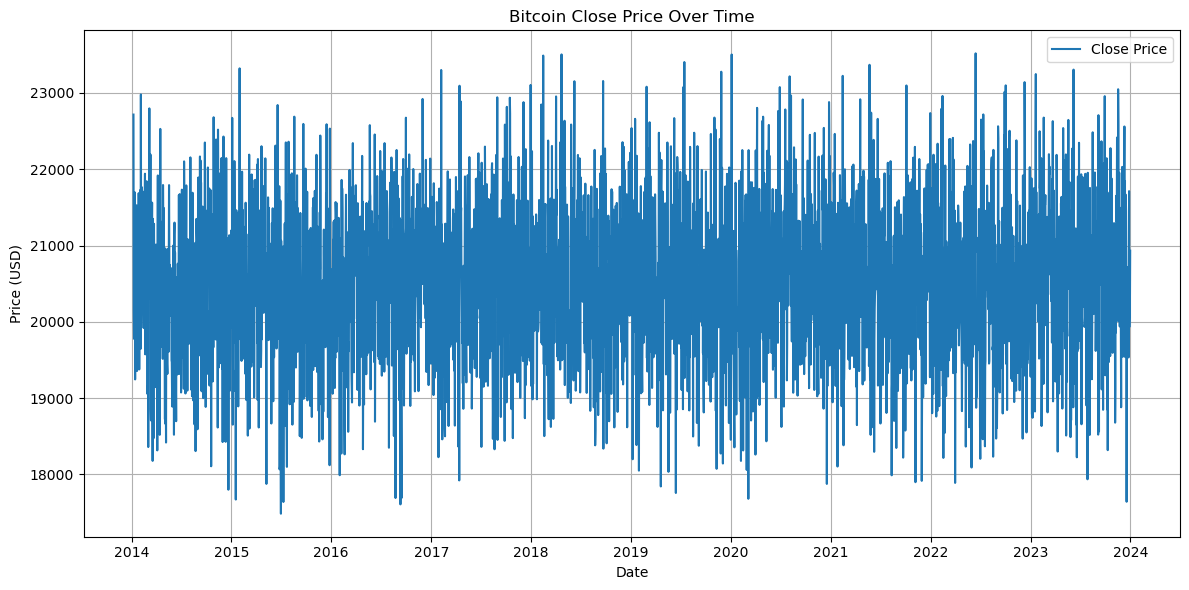

In [16]:
#Line Plot: Close Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(pdf['Date'], pdf['Close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

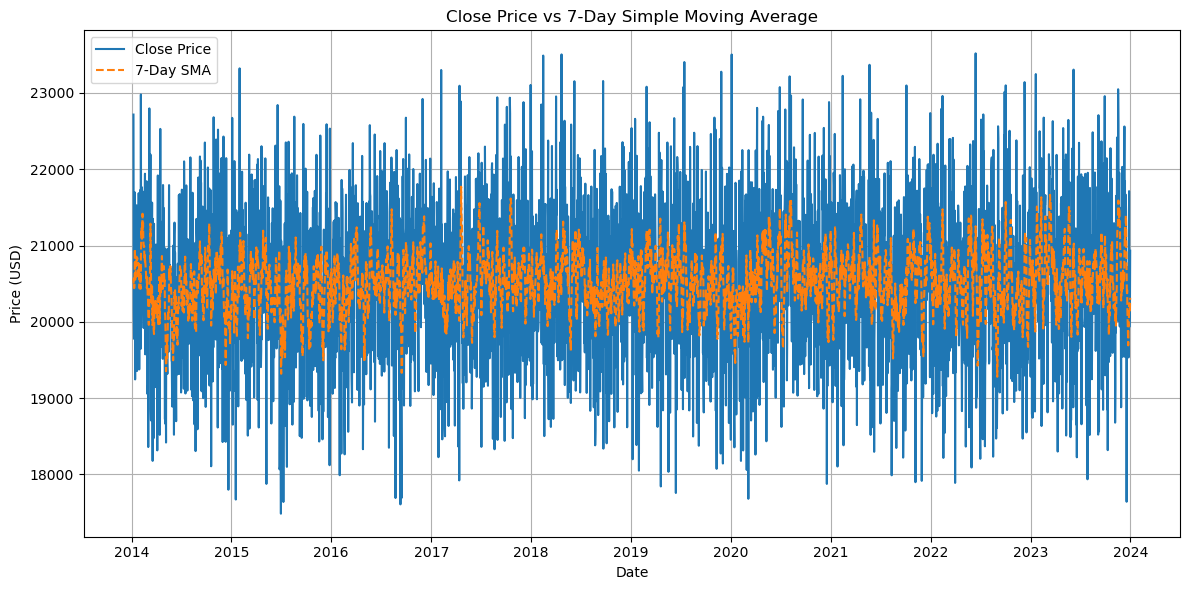

In [17]:
#Close Price vs 7-Day SMA
plt.figure(figsize=(12, 6))
plt.plot(pdf['Date'], pdf['Close'], label='Close Price')
plt.plot(pdf['Date'], pdf['Close_SMA_7'], label='7-Day SMA', linestyle='--')
plt.title('Close Price vs 7-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


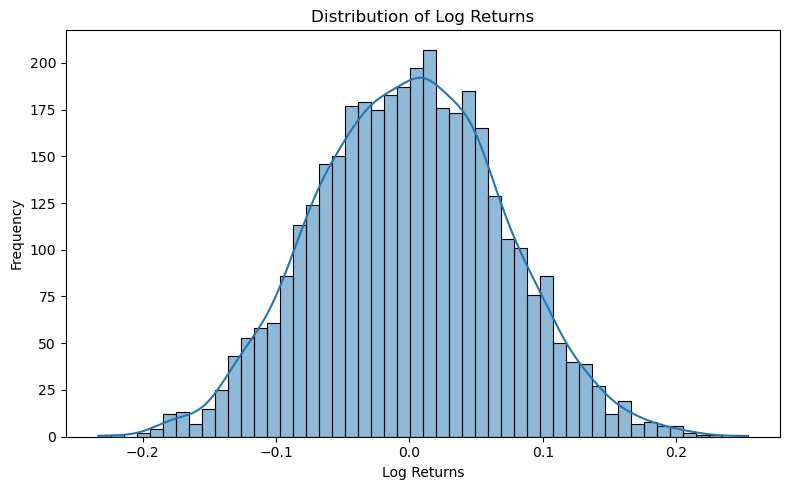

In [18]:
#Histrogram: Log returns
plt.figure(figsize=(8, 5))
sns.histplot(pdf['Log_Returns'], bins=50, kde=True)
plt.title('Distribution of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

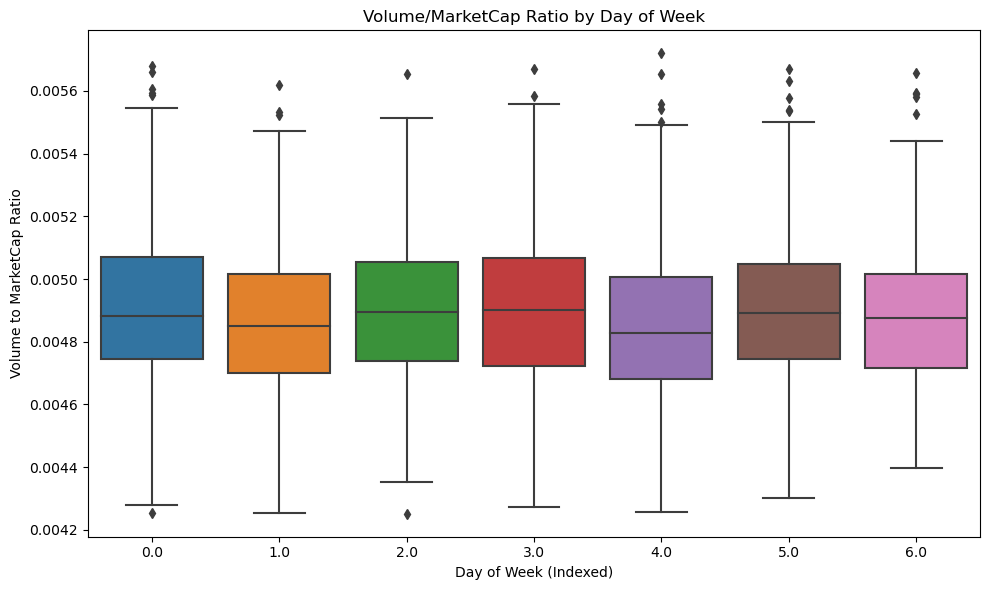

In [19]:
#Boxplot: Volume-to-MarketCap Ratio by Day of Week
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek_Index', y='Volume_to_MarketCap_Ratio', data=pdf)
plt.title('Volume/MarketCap Ratio by Day of Week')
plt.xlabel('Day of Week (Indexed)')
plt.ylabel('Volume to MarketCap Ratio')
plt.tight_layout()
plt.show()

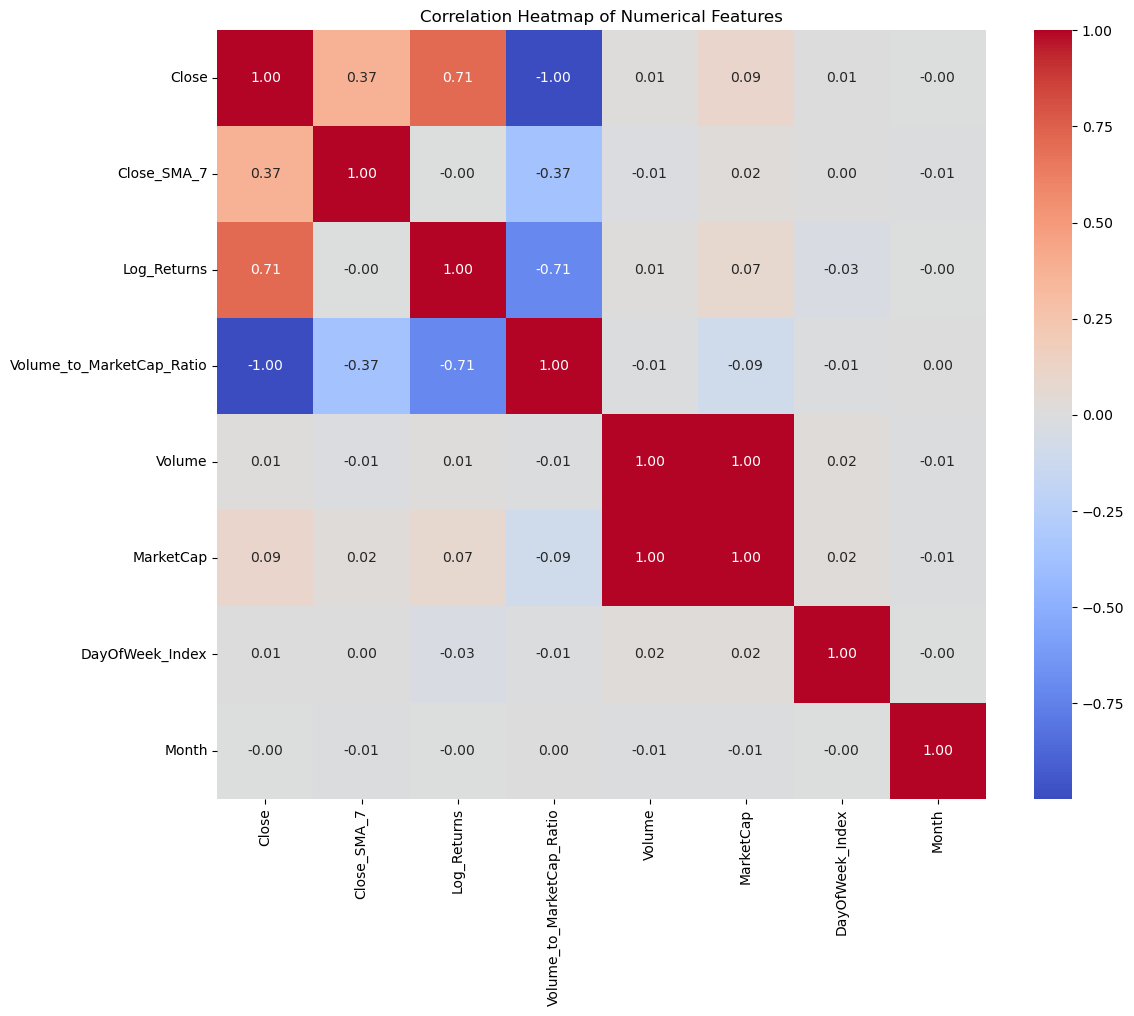

In [20]:
#Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = pdf.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [21]:
summary = pdf[["Close", "Volume", "MarketCap", "Log_Returns"]].describe()
print(summary)

              Close        Volume     MarketCap  Log_Returns
count   3635.000000   3635.000000  3.635000e+03  3635.000000
mean   20515.494776  24983.842641  5.126899e+06     0.000004
std     1000.227305  14307.222294  2.950376e+06     0.069851
min    17483.292079   1010.000000  2.054398e+05    -0.233396
25%    19841.844452  12361.000000  2.504326e+06    -0.048792
50%    20526.636421  24661.000000  5.065160e+06     0.000615
75%    21200.787871  37277.500000  7.642341e+06     0.047524
max    23519.653835  49975.000000  1.144913e+07     0.253709


# Step 4: Model Application 

In [22]:
# Convert x_df and y_df to Pandas (if they are Spark DataFrames)
x = x_df.toPandas()
y = y_df.toPandas()

print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       3635 non-null   object 
 1   CloseLag1                  3635 non-null   float64
 2   CloseLag2                  3635 non-null   float64
 3   CloseLag3                  3635 non-null   float64
 4   CloseLag7                  3635 non-null   float64
 5   OpenLag1                   3635 non-null   float64
 6   OpenLag2                   3635 non-null   float64
 7   OpenLag3                   3635 non-null   float64
 8   OpenLag7                   3635 non-null   float64
 9   HighLag1                   3635 non-null   float64
 10  HighLag2                   3635 non-null   float64
 11  HighLag3                   3635 non-null   float64
 12  HighLag7                   3635 non-null   float64
 13  LowLag1                    3635 non-null   float

In [23]:
# Drop Date column (not needed for modelling)
X = x.drop(columns=["Date"])

# Extract Target column
y = y["Target"]


In [24]:
# Prepare for raw data or unfeatured data and uncleaned 
import pandas as pd 
df=pd.read_csv('synthetic_bitcoin_2014_2023.csv')
print(df.head())
x_raw = df[["Open", "High", "Low", "Volume", "MarketCap"]]
y_raw = df["Close"]


         Date          Open          High           Low         Close  Volume  \
0  2014-01-01  20968.082996  20829.911711  20870.791135  20945.270522   19033   
1  2014-01-02  19522.471940  19797.146771  19423.537426  19674.704767   36088   
2  2014-01-03  20701.451381  20785.331154  20329.565016  20650.369621   44465   
3  2014-01-04  20938.487866  20980.019406  20754.128596  20866.669464   18527   
4  2014-01-05  20456.964155  20312.142865  20309.665065  20509.473482   12964   

      MarketCap  
0  3.986513e+06  
1  7.100207e+06  
2  9.182187e+06  
3  3.865968e+06  
4  2.658848e+06  


In [25]:
# Split training data and testing data 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Featured and cleared data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split raw Data
x_train_raw,x_test_raw,y_train_raw,y_test_raw=train_test_split(x_raw,y_raw,test_size=0.2,random_state=42)


### Linear Regression

In [26]:
# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on Test set
y_pred_lr = lin_reg.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Linear Regression Performance:
MAE  : 29.2604
MSE  : 1967.4146
RMSE : 44.3555
R²   : 0.9979


In [27]:
# Train Linear Regression model on RAW DATA
lin_reg_raw = LinearRegression()
lin_reg_raw.fit(x_train_raw, y_train_raw)

# Predict using RAW TEST DATA
y_pred_raw = lin_reg_raw.predict(x_test_raw)

# Evaluate performance (RAW)
mae_raw = mean_absolute_error(y_test_raw, y_pred_raw)
mse_raw = mean_squared_error(y_test_raw, y_pred_raw)
rmse_raw = np.sqrt(mse_raw)
r2_raw = r2_score(y_test_raw, y_pred_raw)

print("\nPERFORMANCE (RAW DATA)")
print(f"MAE  : {mae_raw:.4f}")
print(f"MSE  : {mse_raw:.4f}")
print(f"RMSE : {rmse_raw:.4f}")
print(f"R²   : {r2_raw:.4f}")



PERFORMANCE (RAW DATA)
MAE  : 31.1866
MSE  : 1525.1707
RMSE : 39.0534
R²   : 0.9986


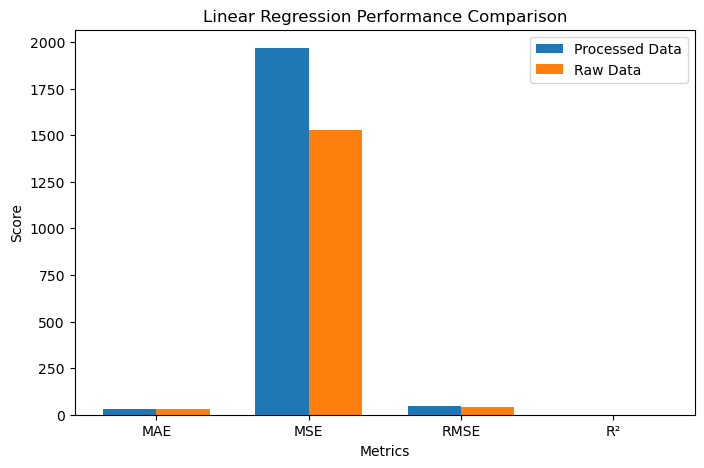

In [28]:

# ---- Metrics in List Form ----
metrics = ["MAE", "MSE", "RMSE", "R²"]
processed_scores = [mae, mse, rmse, r2]
raw_scores = [mae_raw, mse_raw, rmse_raw, r2_raw]

x = np.arange(len(metrics))
width = 0.35  # bar width

plt.figure(figsize=(8,5))
plt.bar(x - width/2, processed_scores, width, label="Processed Data")
plt.bar(x + width/2, raw_scores, width, label="Raw Data")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Linear Regression Performance Comparison")
plt.xticks(x, metrics)
plt.legend()
plt.show()



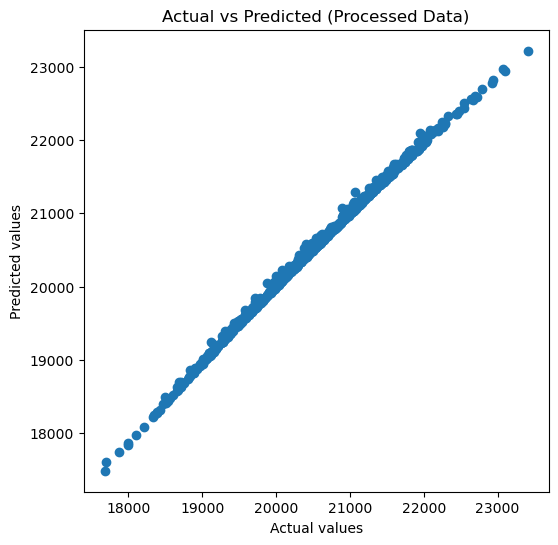

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted (Processed Data)")
plt.show()


### RandomForestRegressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Define the Hyper parameter grid for RandomForestRegressor
param_grid={
    'n_estimators':[50,100,200],
    'max_depth':[None,10,20],
    'max_features':['sqrt','log2',None]
}

grid_search=GridSearchCV(
    estimator=RandomForestRegressor(random_state=32),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train,y_train)

#display best parameters ans score
print(f"Best Parameters from featured Data:{grid_search.best_params_}")

print(f"Best performance with Raw Data :{grid_search.fit(x_test_raw,y_test_raw).best_params_}")

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters from featured Data:{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
Best performance with Raw Data :{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [35]:
# Train RandomForestRegressor model 

rf_model=RandomForestRegressor(
    n_estimators=50,     # Number of trees
    max_depth=None,  
    max_features='sqrt',
    random_state=32)


rf_model.fit(X_train,y_train)

# Predict on Test set
y_pred_rf=rf_model.predict(X_test)

# Evaluate model performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse)
r2_rf = r2_score(y_test, y_pred_rf)

print("RandomForestRegression Performance:")
print(f"MAE  : {mae_rf:.4f}")
print(f"MSE  : {mse_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"R²   : {r2_rf:.4f}")


RandomForestRegression Performance:
MAE  : 81.6989
MSE  : 17364.6049
RMSE : 44.3555
R²   : 0.9812


In [36]:
# Train RandomForestRegressor model 

rf_model_raw = RandomForestRegressor(
    n_estimators=50,     # Number of trees
    max_depth=None,  
    max_features='sqrt',
    random_state=32)

rf_model_raw.fit(x_train_raw, y_train_raw)

# Predict on Test set
y_pred_rf_raw = rf_model_raw.predict(x_test_raw)

# Evaluate model performance
mae_rf_raw = mean_absolute_error(y_test_raw, y_pred_rf_raw)
mse_rf_raw = mean_squared_error(y_test_raw, y_pred_rf_raw)
rmse_rf_raw = np.sqrt(mse_rf_raw)
r2_rf_raw = r2_score(y_test_raw, y_pred_rf_raw)

print("RandomForestRegression Performance (RAW DATA):")
print(f"MAE  : {mae_rf_raw:.4f}")
print(f"MSE  : {mse_rf_raw:.4f}")
print(f"RMSE : {rmse_rf_raw:.4f}")
print(f"R²   : {r2_rf_raw:.4f}")

RandomForestRegression Performance (RAW DATA):
MAE  : 34.9328
MSE  : 1895.4806
RMSE : 43.5371
R²   : 0.9983


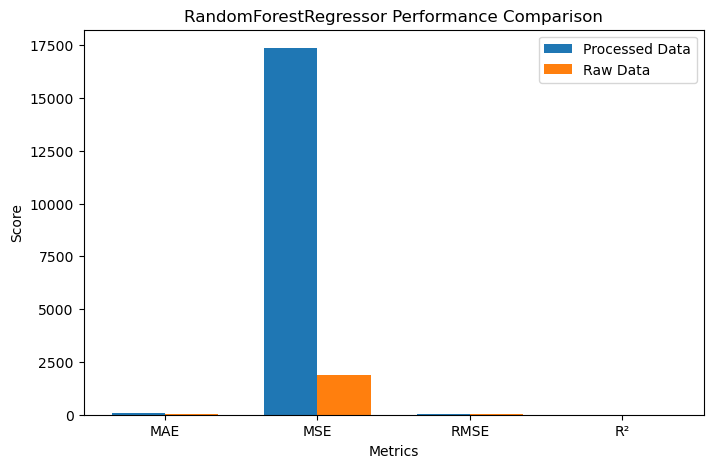

In [37]:
# ---- Metrics in List Form ----
metrics = ["MAE", "MSE", "RMSE", "R²"]
processed_scores = [mae_rf, mse_rf, rmse_rf, r2_rf]
raw_scores = [mae_rf_raw, mse_rf_raw, rmse_rf_raw, r2_rf_raw]

x = np.arange(len(metrics))
width = 0.35  # bar width

plt.figure(figsize=(8,5))
plt.bar(x - width/2, processed_scores, width, label="Processed Data")
plt.bar(x + width/2, raw_scores, width, label="Raw Data")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("RandomForestRegressor Performance Comparison")
plt.xticks(x, metrics)
plt.legend()
plt.show()



In [42]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/b8/90/f082b89dd74da8ca27f8a3c7b3e38fc8529a4a14eb2c5b0937c7d66aa922/xgboost-3.1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 187.9 kB/s eta 0:06:23
   ---------------------------------------- 0.0/72.0 MB 196.9 kB/s eta 0:06:06
   ---------------------------------------- 0.0/72.0 MB 196.9 kB/s eta 0:06:06
   ---------------------------------------- 0.1/72.0 MB 193.2 kB/s eta 0:06:13
   ---------------------------------------- 0.1/72.0 MB 218.6 kB/s eta 0:05:29
   ---------------------------------------- 0.1/72.0 MB 285.2 kB/s eta 0:04:12
   ---------------------------------------- 0.1/72.0 MB 341.3 kB/s eta 0:03:31
   -----------------------------

   ------------------------------ --------- 55.3/72.0 MB 171.1 kB/s eta 0:01:38
   ------------------------------ --------- 55.3/72.0 MB 171.1 kB/s eta 0:01:38
   ------------------------------ --------- 55.3/72.0 MB 171.1 kB/s eta 0:01:38
   ------------------------------ --------- 55.4/72.0 MB 171.3 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.3 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.9 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.9 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.9 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.4 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.4 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.4 kB/s eta 0:01:37
   ------------------------------ --------- 55.4/72.0 MB 171.4 kB/s eta 0:01:37
   ------------------------------ ------

XGBoostRegressor

In [41]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

#  Base Model
model = XGBRegressor(random_state=42)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

#  GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,              # 3-fold Cross Validation
    scoring='r2',      # Can use 'mean_squared_error' also
    n_jobs=-1,         # Use all CPU cores
    verbose=1
)

grid.fit(X_train, y_train)     # Train grid search

print("\nBest Parameters:")
print(grid.best_params_)

# Evaluate Model
best_model = grid.best_estimator_   # Best XGBRegressor

y_pred_xgb = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("\nEvaluation Metrics for XGBRegressor :")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


ModuleNotFoundError: No module named 'xgboost'

In [30]:
#  Base Model
model_raw = XGBRegressor(random_state=42)

#  GridSearchCV
grid_raw = GridSearchCV(
    estimator=model_raw,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_raw.fit(x_train_raw, y_train_raw)

print("\nBest Parameters (RAW):")
print(grid_raw.best_params_)

# Evaluate Model
best_model_raw = grid_raw.best_estimator_

y_pred_xgb_raw = best_model_raw.predict(x_test_raw)

mae_xgb_raw = mean_absolute_error(y_test_raw, y_pred_xgb_raw)
mse_xgb_raw = mean_squared_error(y_test_raw, y_pred_xgb_raw)
rmse_xgb_raw = np.sqrt(mse_xgb_raw)
r2_xgb_raw = r2_score(y_test_raw, y_pred_xgb_raw)

print("\n📊 Evaluation Metrics for XGBRegressor (RAW):")
print("MAE:", mae_xgb_raw)
print("MSE:", mse_xgb_raw)
print("RMSE:", rmse_xgb_raw)
print("R² Score:", r2_xgb_raw)


Fitting 3 folds for each of 27 candidates, totalling 81 fits

🔥 Best Parameters (RAW):
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}

📊 Evaluation Metrics for XGBRegressor (RAW):
MAE: 38.637932181248246
MSE: 2559.784599801195
RMSE: 50.59431390780188
R² Score: 0.997704351010824


c:\Users\bnsah\OneDrive\文档\PROJECTS(FINAL)\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:39:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "max_features" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
